In [22]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torchvision import datasets, transforms, models

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [23]:
# ✅ Define dataset path
dataset_dir = "processed_dataset_split"

# ✅ Custom function to assign severity labels
def get_corrosion_label(image_path):
    if "1hr" in image_path or "1day" in image_path:
        return 0  # Low Corrosion
    elif "7days" in image_path:
        return 1  # Moderate Corrosion
    elif "14days" in image_path or "21days" in image_path:
        return 2  # Severe Corrosion
    else:
        return None

# ✅ Custom Dataset Loader with Correct Labels
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)
        new_samples = []
        root_abs = os.path.abspath(root)  # Get absolute path of dataset root

        for img_path, _ in self.samples:
            full_path = os.path.join(root_abs, os.path.relpath(img_path, root))  # Ensure correct relative path
            label = get_corrosion_label(full_path)

            if label is not None:
                new_samples.append((full_path, label))

        self.samples = new_samples

In [24]:
# ✅ Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
])

from torch.utils.data import DataLoader

# ✅ Define dataset paths correctly
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# ✅ Load datasets with corrected paths
train_dataset = CustomImageFolder(train_dir, transform=transform)
val_dataset = CustomImageFolder(val_dir, transform=transform)
test_dataset = CustomImageFolder(test_dir, transform=transform)

# ✅ Define batch size
batch_size = 16

# ✅ Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Print dataset summary
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 89
Validation samples: 12
Test samples: 16


In [25]:
# ✅ Compute class weights for imbalanced dataset
class_labels = ["Low Corrosion", "Moderate Corrosion", "Severe Corrosion"]
all_labels = [label for _, label in train_dataset.samples]
computed_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(computed_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [26]:
# ✅ Training Function
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, model_name, epochs):
    best_loss = float("inf")
    patience_counter = 0  # For early stopping
    history = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100.0 * correct / total
        train_loss = running_loss / len(train_loader)
        history["train_acc"].append(train_acc)
        history["train_loss"].append(train_loss)

        print(f"{model_name} - Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%")
        scheduler.step(train_loss)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100.0 * correct / total
        val_loss /= len(val_loader)
        print(f"Validation - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > 15:
            print("Early stopping triggered.")
            break

    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history, f, indent=4)

In [27]:
# ✅ Train a ResNet50 Model (Feature Extraction)
resnet_model = models.resnet50(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 3)  # 3 classes
resnet_model = resnet_model.to(device)

optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_model(resnet_model, criterion, optimizer, scheduler, train_loader, val_loader, "resnet50_baseline", epochs=50)

/home/senghuyjr11/Drive/001_ProjectML/SEMClassify/.venv/lib64/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/senghuyjr11/Drive/001_ProjectML/SEMClassify/.venv/lib64/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/senghuyjr11/Drive/001_ProjectML/SEMClassify/.venv/lib64/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


resnet50_baseline - Epoch 1: Loss=1.1761, Train Acc=29.21%
Validation - Loss: 1.1014, Acc: 33.33%
resnet50_baseline - Epoch 2: Loss=1.0486, Train Acc=53.93%
Validation - Loss: 1.1287, Acc: 33.33%
resnet50_baseline - Epoch 3: Loss=0.9753, Train Acc=55.06%
Validation - Loss: 1.0904, Acc: 41.67%
resnet50_baseline - Epoch 4: Loss=0.9078, Train Acc=57.30%
Validation - Loss: 0.9508, Acc: 50.00%
resnet50_baseline - Epoch 5: Loss=0.8516, Train Acc=64.04%
Validation - Loss: 0.9954, Acc: 58.33%
resnet50_baseline - Epoch 6: Loss=0.8439, Train Acc=58.43%
Validation - Loss: 0.8861, Acc: 58.33%
resnet50_baseline - Epoch 7: Loss=0.8282, Train Acc=64.04%
Validation - Loss: 0.8884, Acc: 75.00%
resnet50_baseline - Epoch 8: Loss=0.7546, Train Acc=64.04%
Validation - Loss: 0.8561, Acc: 50.00%
resnet50_baseline - Epoch 9: Loss=0.7545, Train Acc=66.29%
Validation - Loss: 0.8072, Acc: 66.67%
resnet50_baseline - Epoch 10: Loss=0.7319, Train Acc=69.66%
Validation - Loss: 0.6640, Acc: 58.33%
resnet50_baseline -

In [28]:
# ✅ Train Fine-Tuned Model (Unfreezing Last Layers)
fine_tuned_model = models.resnet50(pretrained=True)

# Freeze all layers first
for param in fine_tuned_model.parameters():
    param.requires_grad = False

# Unfreeze last few layers (layer3, layer4, fc)
for param in fine_tuned_model.layer3.parameters():
    param.requires_grad = True
for param in fine_tuned_model.layer4.parameters():
    param.requires_grad = True
for param in fine_tuned_model.fc.parameters():
    param.requires_grad = True

num_ftrs = fine_tuned_model.fc.in_features
fine_tuned_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 3)  # 3 Classes
)

fine_tuned_model = fine_tuned_model.to(device)
optimizer_finetuned = optim.Adam(filter(lambda p: p.requires_grad, fine_tuned_model.parameters()), lr=0.0001)
scheduler_finetuned = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_finetuned, mode='min', factor=0.5, patience=5, verbose=True
)

train_model(fine_tuned_model, criterion, optimizer_finetuned, scheduler_finetuned, train_loader, val_loader, "resnet50_finetuned", epochs=50)

resnet50_finetuned - Epoch 1: Loss=1.0466, Train Acc=43.82%
Validation - Loss: 1.0404, Acc: 58.33%
resnet50_finetuned - Epoch 2: Loss=0.7531, Train Acc=66.29%
Validation - Loss: 0.7968, Acc: 75.00%
resnet50_finetuned - Epoch 3: Loss=0.5147, Train Acc=79.78%
Validation - Loss: 0.6538, Acc: 75.00%
resnet50_finetuned - Epoch 4: Loss=0.3823, Train Acc=92.13%
Validation - Loss: 0.3870, Acc: 91.67%
resnet50_finetuned - Epoch 5: Loss=0.3010, Train Acc=87.64%
Validation - Loss: 0.5904, Acc: 75.00%
resnet50_finetuned - Epoch 6: Loss=0.2713, Train Acc=88.76%
Validation - Loss: 0.4264, Acc: 83.33%
resnet50_finetuned - Epoch 7: Loss=0.1756, Train Acc=92.13%
Validation - Loss: 0.2508, Acc: 91.67%
resnet50_finetuned - Epoch 8: Loss=0.1629, Train Acc=94.38%
Validation - Loss: 0.1040, Acc: 100.00%
resnet50_finetuned - Epoch 9: Loss=0.1418, Train Acc=94.38%
Validation - Loss: 0.0850, Acc: 100.00%
resnet50_finetuned - Epoch 10: Loss=0.1000, Train Acc=94.38%
Validation - Loss: 0.1612, Acc: 91.67%
resnet5


Model Performance on Test Set:
Accuracy: 81.25%
Precision: 89.29%
Recall: 81.25%
F1-Score: 81.93%


<Figure size 600x500 with 0 Axes>

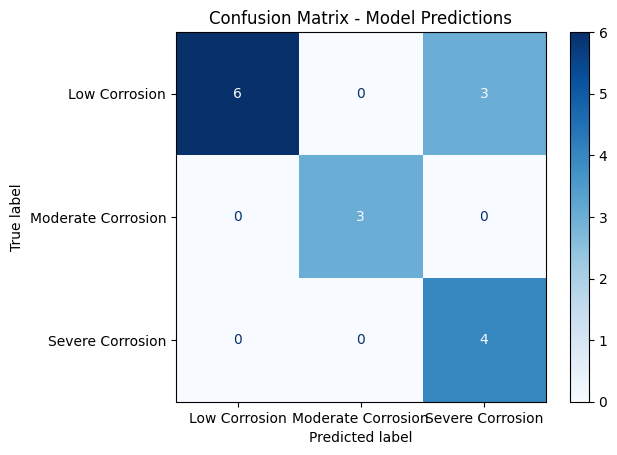

81.25

In [29]:
# ✅ Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute classification metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f"\nModel Performance on Test Set:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1-Score: {f1:.2f}%")

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_labels = ["Low Corrosion", "Moderate Corrosion", "Severe Corrosion"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix - Model Predictions")
    plt.show()

    return accuracy

# Run evaluation after training
evaluate_model(fine_tuned_model, test_loader)

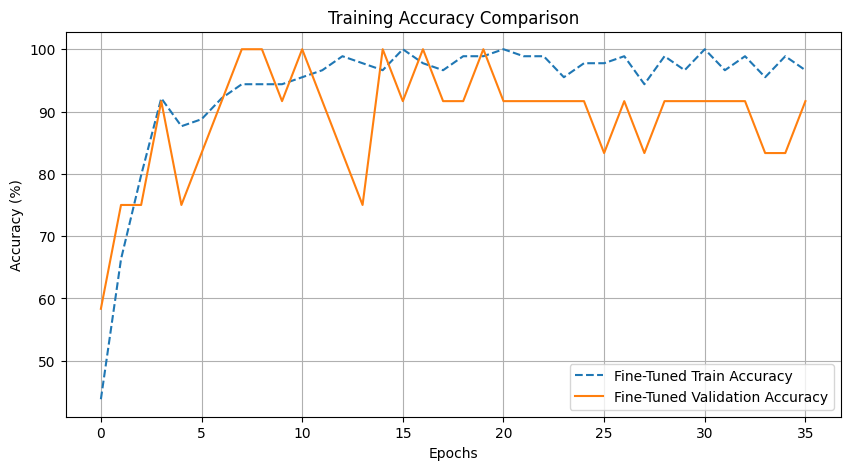

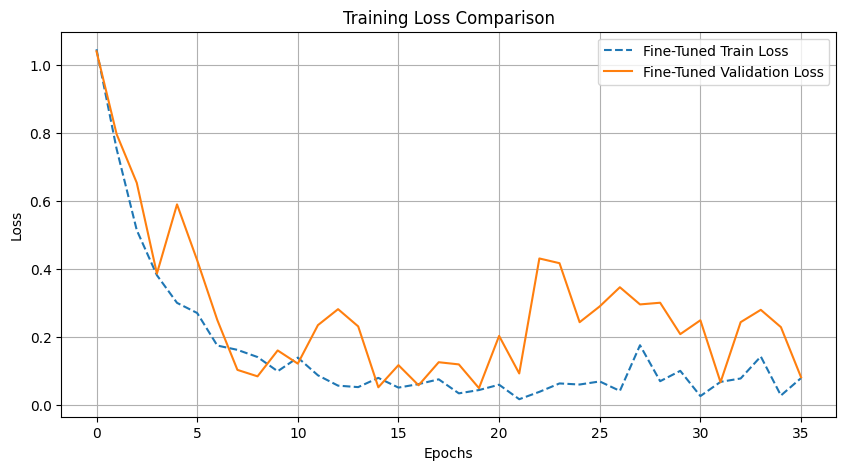

In [30]:
def plot_training_history(finetuned_file):
    import json
    import matplotlib.pyplot as plt

    with open(finetuned_file, "r") as f:
        finetuned_history = json.load(f)

    # Plot Training Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(finetuned_history["train_acc"], label="Fine-Tuned Train Accuracy", linestyle='dashed')
    plt.plot(finetuned_history["val_acc"], label="Fine-Tuned Validation Accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy Comparison")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training Loss
    plt.figure(figsize=(10, 5))
    plt.plot(finetuned_history["train_loss"], label="Fine-Tuned Train Loss", linestyle='dashed')
    plt.plot(finetuned_history["val_loss"], label="Fine-Tuned Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.grid()
    plt.show()

# Call function to plot history after training
plot_training_history("resnet50_finetuned_history.json")